#  Topic Modeling with Gensim 

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

## Let's begin

In [77]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [75]:
# Download NLTK resources (if not already downloaded)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARPITA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ARPITA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##  Import Newsgroups Data 

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [17]:
# NLTK Stop wods
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Remove emails and newline characters 

In [43]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


## Tokenize words and Clean-up text 

In [44]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Creating Bigram and Trigram Models

In [45]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [46]:
from gensim.models import Phrases

# Function to create bigrams from a list of words
def make_bigrams(words):
    bigram = Phrases(words, min_count=5, threshold=100)
    return [bigram[word] for word in words]

# Example usage
data_words_bigrams = make_bigrams(data_words_nostops)


##  Remove Stopwords, Make Bigrams and Lemmatize

In [49]:
# Define functions for removing stopwords, making bigrams, trigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
           tokens = [lemmatizer.lemmatize(word) for word in sent if word not in stop_words]
    texts_out.append(tokens)
    return texts_out

## Let’s call the functions in order.

In [48]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['kevin', 'gunning', 'stolen', 'cbr_rr', 'organization', 'california_institute', 'technology_pasadena', 'line', 'distribution_usa', 'nntp_posting', 'host', 'alumni_caltech', 'summary', 'see', 'stolen', 'pasadena', 'pm', 'blue', 'white', 'honda', 'cbr_rr', 'california', 'plate', 'kg', 'cbr', 'serial_number', 'jh', 'sc', 'xpm', 'engine', 'number', 'turn', 'signal', 'mirror', 'light', 'taped', 'track', 'rider', 'session', 'willow', 'spring', 'tomorrow', 'guess', 'ill', 'miss', 'help', 'find', 'baby', 'kjg']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [50]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]]


## Building the Topic Model

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [54]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (1,
  '0.023*"stolen" + 0.023*"cbr_rr" + 0.022*"number" + 0.022*"willow" + '
  '0.021*"nntp_posting" + 0.021*"light" + 0.021*"see" + 0.021*"tomorrow" + '
  '0.021*"miss" + 0.021*"organization"'),
 (2,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (3,
  '0.040*"stolen" + 0.040*"cbr_rr" + 0.020*"pasadena" + 0.020*"plate" + '
  '0.020*"pm" + 0.020*"distribution_usa" + 0.020*"line" + 0.020*"baby" + '
  '0.020*"host" + 0.020*"help"'),
 (4,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (5,
  '0.021*"rider" + 0.021*"pm" + 0.021

## Model Perplexity and Coherence Score

In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.967375284555007

Coherence Score:  0.9999999999999998


## How to find the optimal number of topics for LDA?

In [56]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Assuming 'corpus' is your bag-of-words corpus and 'id2word' is your dictionary

def compute_coherence_values(corpus, dictionary, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

# Usage
start = 2
limit = 40
step = 6

model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=id2word, texts=data_lemmatized, start=start, limit=limit, step=step)

# Now, 'model_list' contains the list of LDA models, and 'coherence_values' contains the corresponding coherence scores.


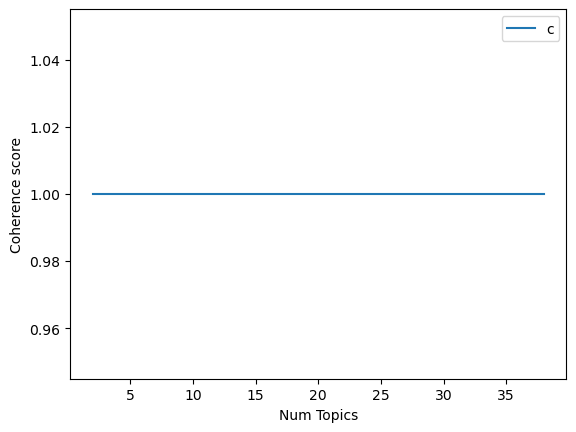

In [57]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 1.0
Num Topics = 8  has Coherence Value of 1.0
Num Topics = 14  has Coherence Value of 1.0
Num Topics = 20  has Coherence Value of 1.0
Num Topics = 26  has Coherence Value of 1.0
Num Topics = 32  has Coherence Value of 1.0
Num Topics = 38  has Coherence Value of 1.0


## Visualizations

if the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [59]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.040*"cbr_rr" + 0.040*"stolen" + 0.021*"alumni_caltech" + 0.021*"miss" + '
  '0.021*"summary" + 0.021*"pasadena" + 0.021*"spring" + 0.021*"cbr" + '
  '0.021*"kevin" + 0.021*"plate"'),
 (1,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (2,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (3,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (4,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (5,
  '0.021*"rider" + 0.021*"pm" + 0.021*

##  Word Clouds

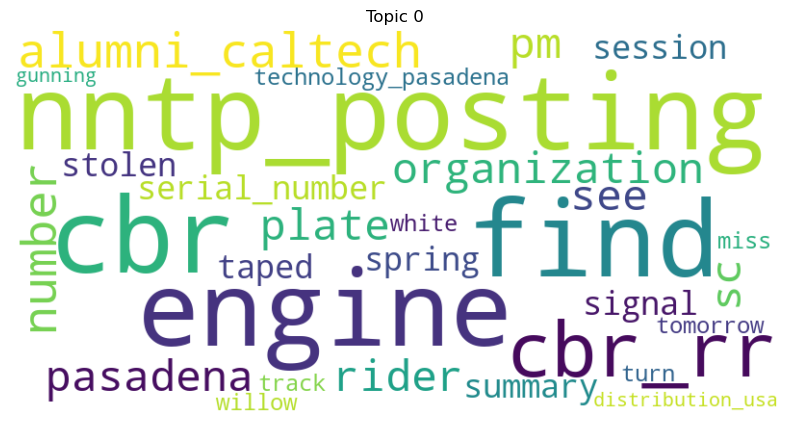

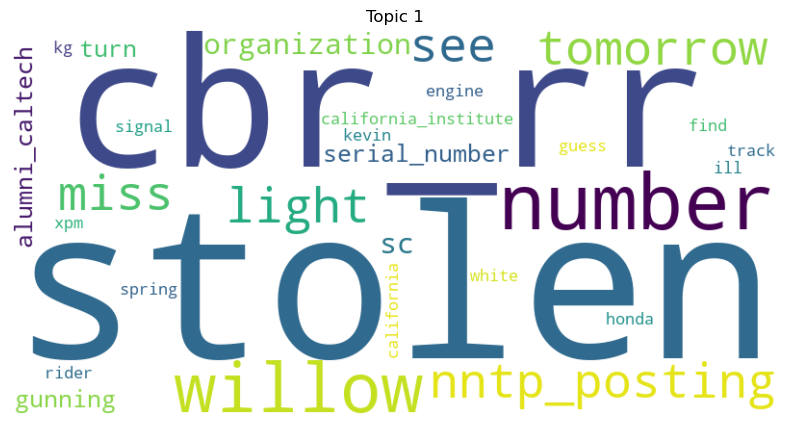

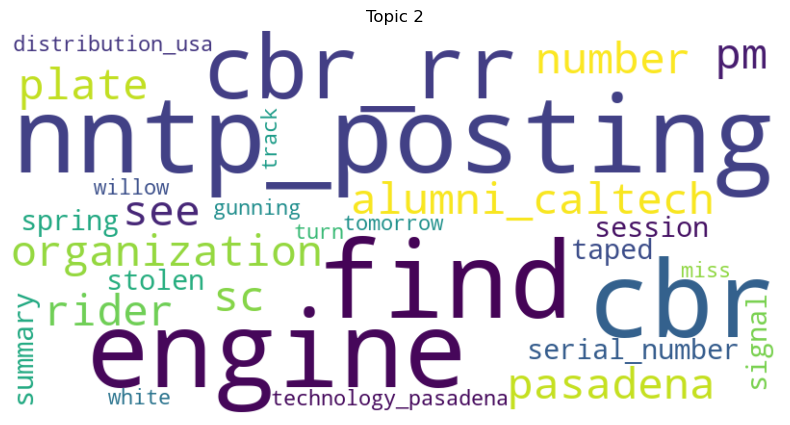

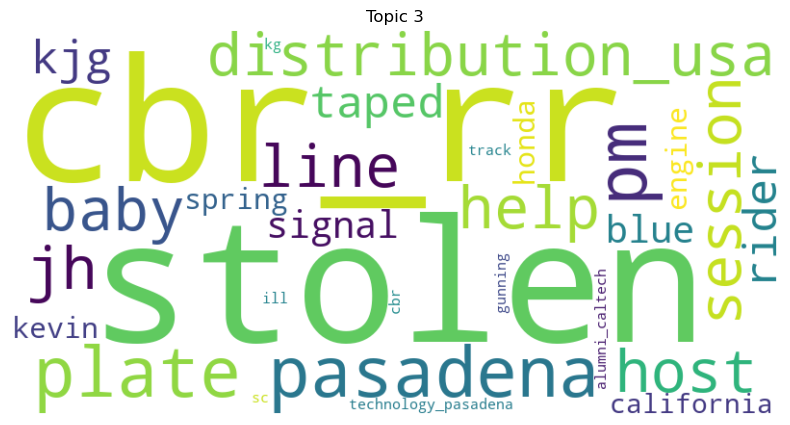

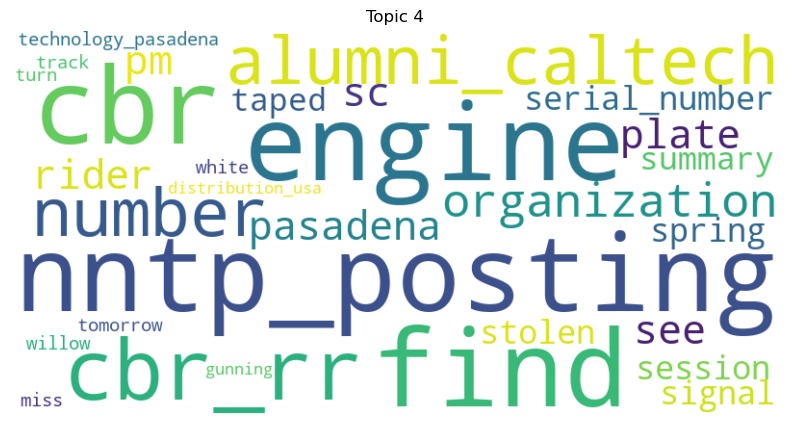

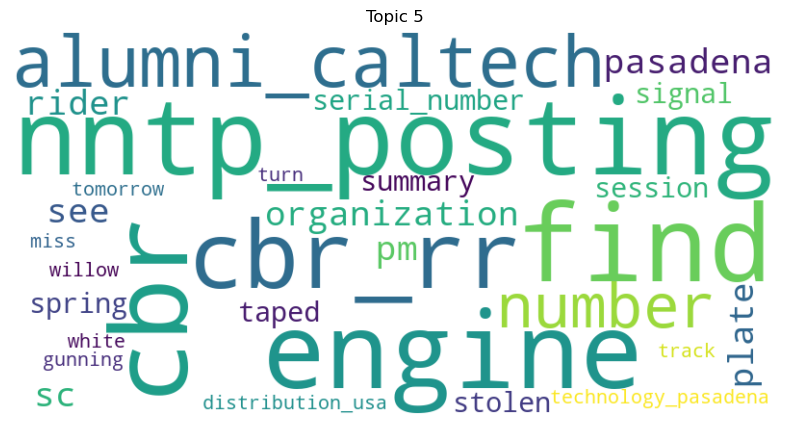

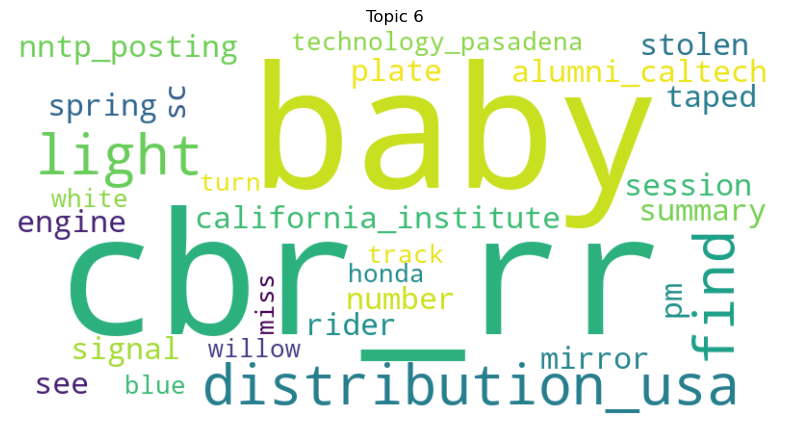

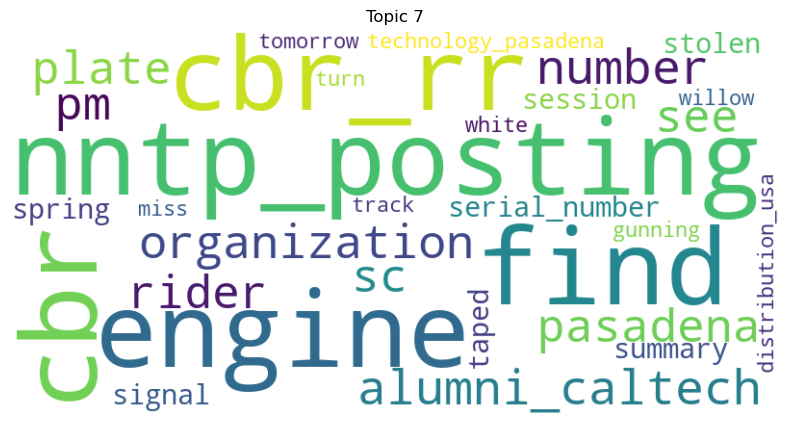

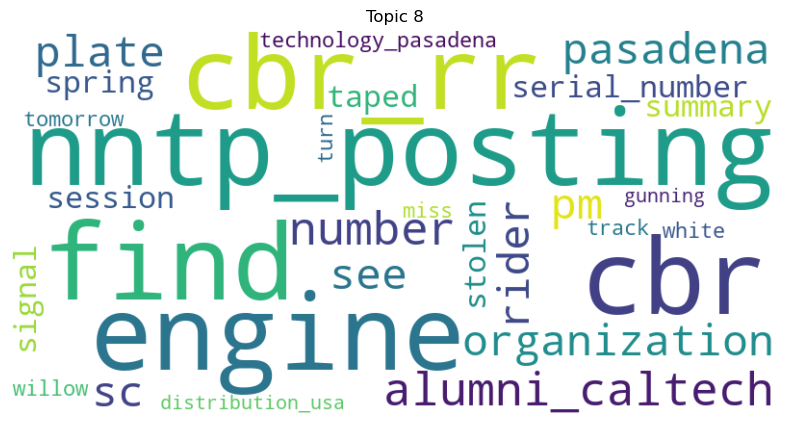

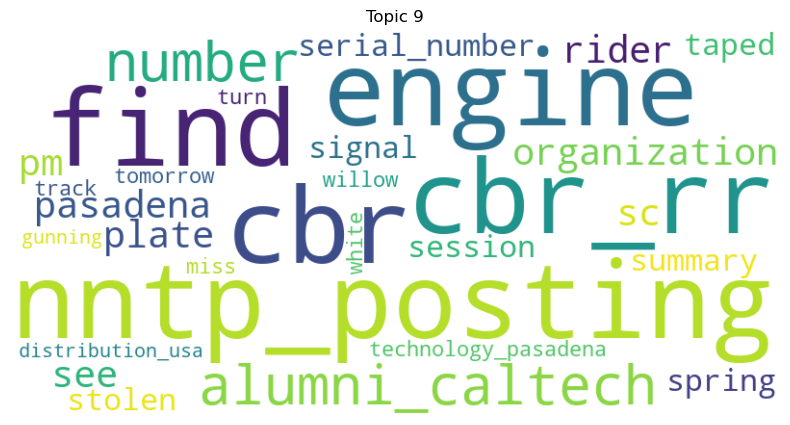

In [88]:
# Visualize Word Clouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_clouds(ldamodel, num_topics):
    for topic_id in range(num_topics):
        words = dict(ldamodel.show_topic(topic_id, topn=30))
        wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_id}')
        plt.show()

# Usage
num_topics = 10  # specify the number of topics
plot_word_clouds(lda_model, num_topics)


## Bar chart 

[(0,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (1,
  '0.023*"stolen" + 0.023*"cbr_rr" + 0.022*"number" + 0.022*"willow" + '
  '0.021*"nntp_posting" + 0.021*"light" + 0.021*"see" + 0.021*"tomorrow" + '
  '0.021*"miss" + 0.021*"organization"'),
 (2,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (3,
  '0.040*"stolen" + 0.040*"cbr_rr" + 0.020*"pasadena" + 0.020*"plate" + '
  '0.020*"pm" + 0.020*"distribution_usa" + 0.020*"line" + 0.020*"baby" + '
  '0.020*"host" + 0.020*"help"'),
 (4,
  '0.021*"rider" + 0.021*"pm" + 0.021*"serial_number" + 0.021*"see" + '
  '0.021*"sc" + 0.021*"signal" + 0.021*"organization" + 0.021*"pasadena" + '
  '0.021*"spring" + 0.021*"plate"'),
 (5,
  '0.021*"rider" + 0.021*"pm" + 0.021

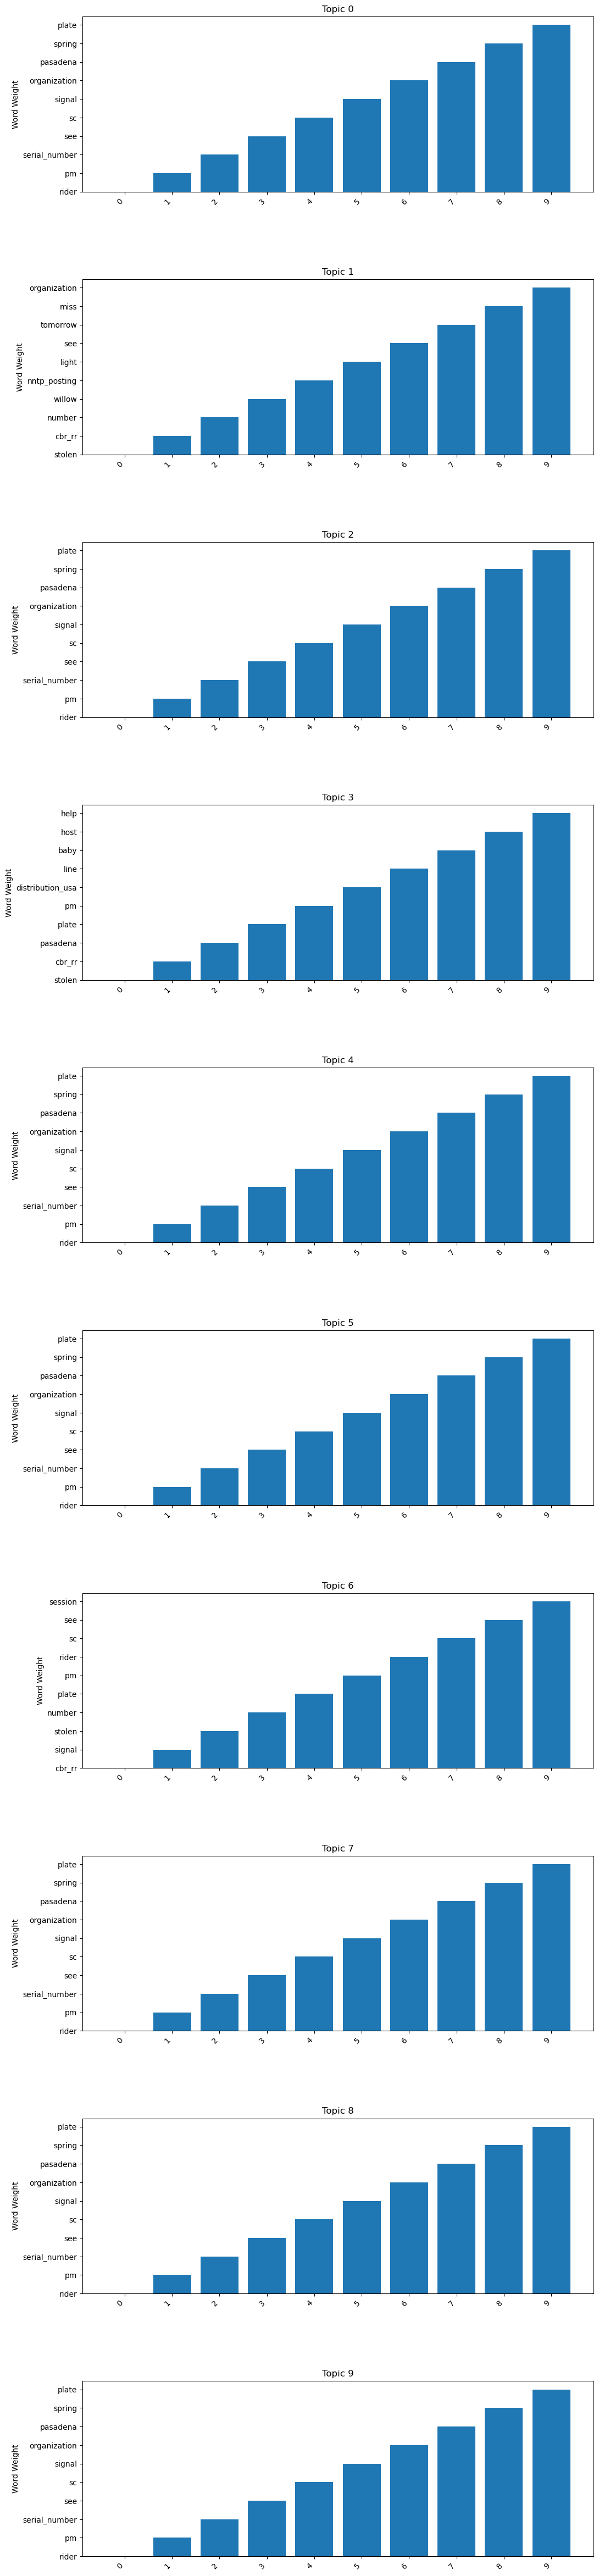

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

def plot_top_words(ldamodel, num_topics):
    top_words = []
    for topic_id in range(num_topics):
        words = [word for word, _ in ldamodel.show_topic(topic_id, topn=10)]
        top_words.append(words)
    df = pd.DataFrame(top_words).T
    df.columns = [f'Topic {i}' for i in range(num_topics)]

    fig, axs = plt.subplots(nrows=num_topics, figsize=(12, 6 * num_topics))
    plt.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axs):
        ax.bar(df.index, df[f'Topic {i}'])
        ax.set_xticks(range(len(df)))
        ax.set_xticklabels(df.index, rotation=45, ha="right")
        ax.set_title(f'Topic {i}')
        ax.set_ylabel('Word Weight')
    
    plt.show()

# Usage
num_topics = 10  # specify the number of topics
plot_top_words(lda_model, num_topics)


## Heatmap 

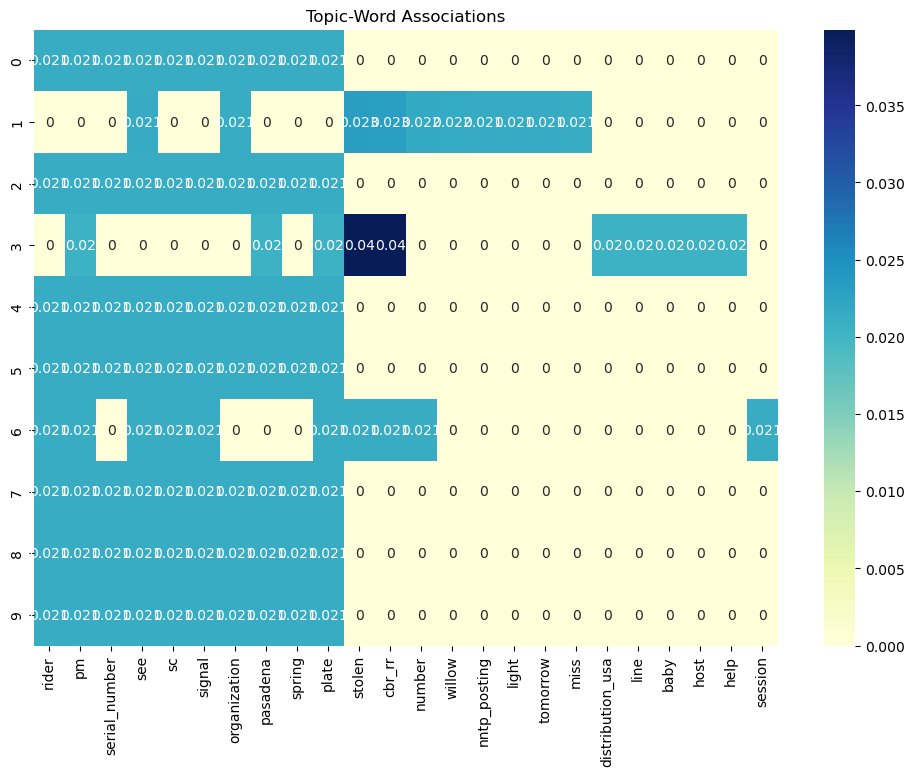

In [106]:
import seaborn as sns

def plot_topic_word_heatmap(lda_model, num_topics):
    topic_words = []
    for topic_id in range(num_topics):
        words = dict(lda_model.show_topic(topic_id, topn=10))
        topic_words.append(words)
    df = pd.DataFrame(topic_words).fillna(0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap='YlGnBu')
    plt.title('Topic-Word Associations')
    plt.show()

# Usage
plot_topic_word_heatmap(lda_model, num_topics)


## Finding the dominant topic in each sentence

In [69]:
import pandas as pd

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Initialize a list to store the data
    data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data.append({'Dominant_Topic': int(topic_num),
                             'Perc_Contribution': round(prop_topic, 4),
                             'Topic_Keywords': topic_keywords,
                             'Text': texts[i]})
            else:
                break

    # Create a DataFrame from the collected data
    df_topic_sents_keywords = pd.DataFrame(data)
    
    return df_topic_sents_keywords

# Usage
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_topic_sents_keywords.head()


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0,0.981,"cbr_rr, stolen, alumni_caltech, miss, summary,...",From: (wheres my thing) Subject: WHAT car is t...


## Find the most representative document for each topic

In [63]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.981,"cbr_rr, stolen, alumni_caltech, miss, summary,...",From: (wheres my thing) Subject: WHAT car is t...


## Topic distribution across documents

In [62]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"cbr_rr, stolen, alumni_caltech, miss, summary,...",1,1.0


## Conclusion

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA. We also saw how to find the optimal number of topics using coherence scores and how  can we  come to a logical understanding of how to choose the optimal model. Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.